 ## What does this code do?



 We compute simple returns $ r_{ji} = P_{ji} - P_{j, i-1} $  for the $j$-th market at interval $i$.



 Because prices can be zero or negative, log returns are not applicable.



 Following Andersen et al. (2001) and Bollerslev et al. (2020), we estimate the realized daily variation and covariation using the covariance matrix definition:


$$
\text{ReCov} = \sum_{i=1}^m r_i r_i' = 
\begin{bmatrix}
\text{ReVar}_{FR} & \text{ReCov}_{FR-ES} & \text{ReCov}_{FR-PT} \\
\text{ReCov}_{ES-FR} & \text{ReVar}_{ES} & \text{ReCov}_{ES-PT} \\
\text{ReCov}_{PT-FR} & \text{ReCov}_{PT-ES} & \text{ReVar}_{PT}
\end{bmatrix}
$$




 To prepare for the multivariate HAR (MHAR) model (Corsi, 2009), we apply a **variance stabilizer** based on the Probability Integral Transform (PIT) following Uniejewski et al. (2017):

 $$

 Z_t = G^{-1}(\hat{F}(X_t))

 $$

 where $X_t$ is the realized measure, $\hat{F}$ its estimated CDF, and $G^{-1}$ the inverse standard normal CDF.



 This transformation is used to approximate normality of the realized measures, which is important for the generalized variance decomposition step.

 ## Step 1: Load data and handle DST duplicates

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from scipy.stats import norm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output


In [2]:
# --- Create dropdown ---
option_selector = widgets.Dropdown(
    options=['europe', 'australia'],
    value='europe',  # initial default
    description='Dataset:',
    disabled=False,
)

# --- Create button ---
button = widgets.Button(
    description="Load Dataset",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to load selected dataset',
    icon='check'  # (optional) FontAwesome icon
)

# --- Define button click handler ---
def on_button_click(b):
    global df
    clear_output(wait=True)  # Clears previous output to keep it clean
    display(option_selector, button)  # Re-display widgets after clear
    
    selected_option = option_selector.value
    
    if selected_option == 'europe':
        file_path = 'parquet_files/filtered_data.parquet'
        try:
            df = pd.read_parquet(file_path)
            print(f"✅ Europe dataset loaded from {file_path}.")
            print(df.head())
        except Exception as e:
            print(f"❌ Error loading Europe dataset: {e}")
    
    elif selected_option == 'australia':
        file_path = 'parquet_files/filtered_data_australia.parquet'
        try:
            df = pd.read_parquet(file_path)
            print(f"✅ Australia dataset loaded from {file_path}.")
            print(df.head())
        except Exception as e:
            print(f"❌ Error loading Australia dataset: {e}")

# --- Attach button click handler ---
button.on_click(on_button_click)

# --- Display UI ---
display(option_selector, button)

Dropdown(description='Dataset:', index=1, options=('europe', 'australia'), value='australia')

Button(button_style='success', description='Load Dataset', icon='check', style=ButtonStyle(), tooltip='Click t…

In [3]:
if option_selector.value == 'europe':
    # Sort and disambiguate duplicated timestamps caused by DST
    df = df.sort_values(['Area', 'Start DateTime'])
    df['dup_rank'] = df.groupby(['Area', 'Start DateTime']).cumcount()
    df['Start DateTime Unique'] = df['Start DateTime'] + pd.to_timedelta(df['dup_rank'], unit='s')

    # Pivot to get prices in wide format (rows = times, columns = markets)
    df_pivot = df.pivot(index='Start DateTime Unique', columns='Area', values='Day-ahead Price (EUR/MWh)').sort_index()
    df_pivot.head(5)
else:
    df['Start DateTime Unique'] = df['Start DateTime']

    # Pivot to get prices in wide format (rows = times, columns = markets)
    df_pivot = df.pivot(index='Start DateTime Unique', columns='Area', values='Day-ahead Price (EUR/MWh)').sort_index()
    df_pivot.head(5)


 ## Step 2: Compute simple returns

In [5]:
# Calculate simple returns: \(r_{ji} = P_{ji} - P_{j,i-1}\)
simple_returns = df_pivot.diff().dropna()
simple_returns.head(5)


Area,nsw,qld,sa,tas,vic
Start DateTime Unique,,,,,
2009-07-01 00:05:00,0.768261,1.160089,1.090210,0.385499,0.00000
2009-07-01 00:10:00,-0.030880,-0.192490,0.302669,-0.154579,-0.11000
2009-07-01 00:15:00,-0.942432,-0.006299,-0.499500,-1.629330,-2.57703
2009-07-01 00:20:00,-1.097372,-0.961300,-1.289570,-1.031640,-1.01297
2009-07-01 00:25:00,-1.910073,-1.923970,-4.372559,-2.112760,1.06755


 ## Step 3: Calculate daily realized covariance matrices

In [6]:
# Add date column to group by day
simple_returns['Date'] = simple_returns.index.date

# Prepare a dict to store daily covariance DataFrames
daily_covariances = {}

# Loop through each day to compute daily realized covariance matrices
for day, group in simple_returns.groupby('Date'):
    returns_only = group.drop(columns='Date')
    cov_matrix = np.zeros((returns_only.shape[1], returns_only.shape[1]))
    for i in range(returns_only.shape[0]):
        r = returns_only.iloc[i].values.reshape(-1, 1)
        cov_matrix += r @ r.T
    daily_covariances[day] = pd.DataFrame(cov_matrix, index=returns_only.columns, columns=returns_only.columns)


In [7]:
# Print the first day covariance matrix
first_key, first_value = next(iter(daily_covariances.items()))
print(first_key)
print(first_value)

2009-07-01
Area          nsw         qld           sa           tas         vic
Area                                                                
nsw   1235.554971  475.459351  1712.430651   2827.001259  624.115158
qld    475.459351  475.359984   284.854716    651.697397  448.116422
sa    1712.430651  284.854716  6361.076215   1034.661122  545.766451
tas   2827.001259  651.697397  1034.661122  10696.216454  997.984823
vic    624.115158  448.116422   545.766451    997.984823  619.664690


 ## Step 4: Apply variance stabilizer (PIT transformation) to daily realized variances

In [8]:
# Extract realized variances (diagonal of daily covariance matrices) into a DataFrame
daily_vars = pd.DataFrame(
    {
        day: pd.Series(np.diag(cov), index=cov.index)  # Use cov.index as labels for diagonal
        for day, cov in daily_covariances.items()
    }
).T  # transpose to have days as rows

daily_vars.index = pd.to_datetime(daily_vars.index)

print(daily_vars)


Area                  nsw            qld             sa           tas  \
2009-07-01    1235.554971     475.359984    6361.076215  1.069622e+04   
2009-07-02   36508.966101  314279.969197   11450.718413  1.040328e+04   
2009-07-03    1346.691906    1511.349838    1475.989691  2.030409e+03   
2009-07-04    1183.351100     743.418378    1164.803743  9.178690e+03   
2009-07-05    5212.079291    4938.017722    5169.411958  6.199677e+03   
...                   ...            ...            ...           ...   
2019-02-24   44529.152479   44469.486199  125353.763951  5.605993e+04   
2019-02-25  180212.676970   23308.228850  603045.632869  4.569567e+05   
2019-02-26   28112.638847   18201.318341   88553.558946  9.057208e+04   
2019-02-27   56225.725797   45567.130857  171126.500710  1.560596e+05   
2019-02-28  298249.920373   17051.577600  730925.238915  2.649279e+06   

Area                  vic  
2009-07-01     619.664690  
2009-07-02   17659.879307  
2009-07-03    1622.974149  
2009-07-04 

C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


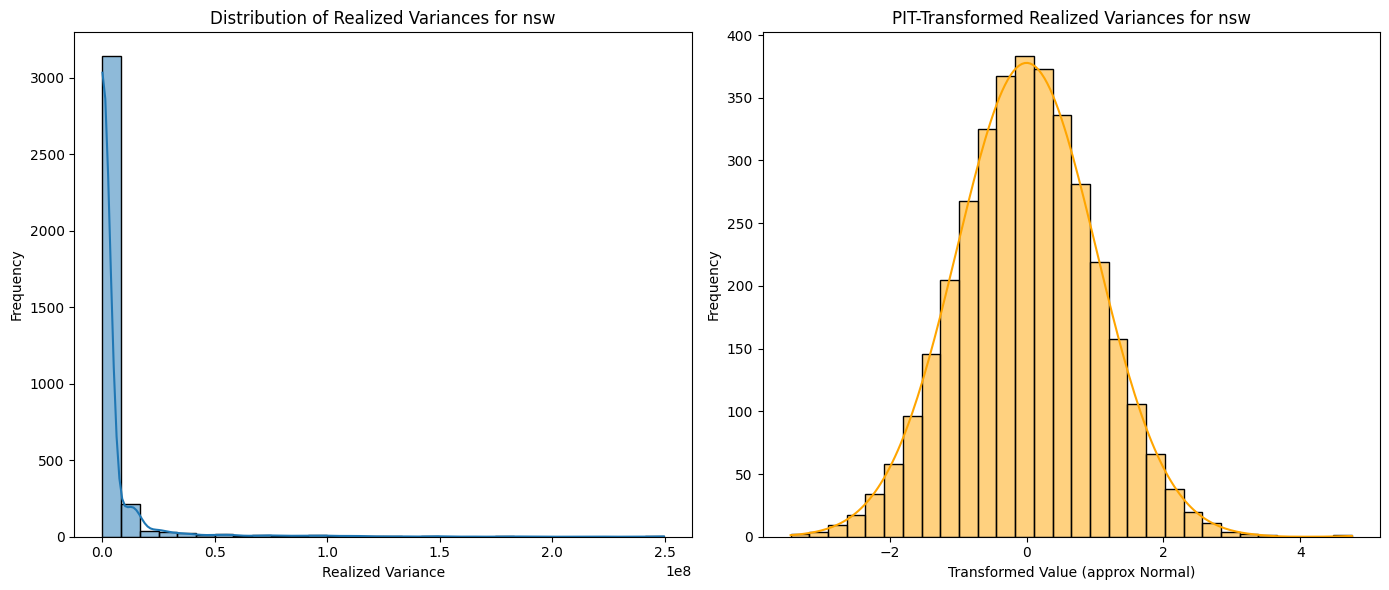

In [9]:
# Estimate the empirical cumulative distribution function (CDF) for each market's realized variances
# and apply the Probability Integral Transform (PIT) to stabilize variance and achieve approximate normality.
#
# The PIT is performed by:
# 1. Sorting the data to estimate the empirical CDF values for each observation.
# 2. Using these CDF values as inputs to the inverse standard normal CDF (norm.ppf),
#    which transforms the data to follow an approximately standard normal distribution.
#
# Clipping the CDF values avoids issues with extreme 0 or 1 probabilities, which would
# lead to infinite values after the inverse normal transform.

def pit_transform(x):
    sorted_x = np.sort(x)
    cdf_vals = np.searchsorted(sorted_x, x, side='right') / len(x)
    # Avoid exact 0 or 1 for norm.ppf by clipping
    cdf_vals = np.clip(cdf_vals, 1e-6, 1-1e-6)
    return norm.ppf(cdf_vals)

pit_vars = daily_vars.apply(pit_transform, axis=0)

# Plot distributions before and after PIT transform for a selected market
market = daily_vars.columns[0]  # choose the first market as example

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.histplot(daily_vars[market], bins=30, kde=True)
plt.title(f'Distribution of Realized Variances for {market}')
plt.xlabel('Realized Variance')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(pit_vars[market], bins=30, kde=True, color='orange')
plt.title(f'PIT-Transformed Realized Variances for {market}')
plt.xlabel('Transformed Value (approx Normal)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



 ## Step 5: Save outputs for modeling

In [10]:
# Save simple returns (without Date column)
simple_returns.drop(columns='Date').to_parquet(f"parquet_files/simple_returns_{option_selector.value}.parquet")

# Save daily realized covariance matrices as a single parquet with MultiIndex (day + market pairs)
# Flatten daily covariance matrices into long format for storage
records = []
for day, cov in daily_covariances.items():
    for i, mkt1 in enumerate(cov.index):
        for j, mkt2 in enumerate(cov.columns):
            records.append({'Date': day, 'Market1': mkt1, 'Market2': mkt2, 'Value': cov.iloc[i,j]})

daily_cov_long = pd.DataFrame(records)
daily_cov_long.to_parquet(f"parquet_files/daily_realized_covariances_{option_selector.value}.parquet")

# Save PIT-transformed variances
pit_vars.to_parquet(f"parquet_files/pit_transformed_variances_{option_selector.value}.parquet")


In [11]:
pit_vars

Area,nsw,qld,sa,tas,vic
2009-07-01,-0.699212,-1.271926,-0.097437,-0.011362,-0.901846
2009-07-02,0.282052,1.040695,0.046172,-0.024856,0.442966
2009-07-03,-0.661619,-0.563926,-0.589925,-0.683880,-0.319200
2009-07-04,-0.720222,-0.947581,-0.711049,-0.065375,-0.551482
2009-07-05,-0.212486,-0.117435,-0.153986,-0.218300,0.083889
...,...,...,...,...,...
2019-02-24,0.335682,0.453172,0.644044,0.550656,0.929929
2019-02-25,0.795948,0.318453,1.207615,1.322999,1.778303
2019-02-26,0.219755,0.260687,0.526031,0.658088,0.772767
2019-02-27,0.398740,0.461845,0.783340,0.862034,1.038258
